# Iris Identification using Manual HOG + MLPClassifier (Backpropagation)

This notebook performs iris identification using images of rotated iris regions.  
It extracts features using **manually implemented Histogram of Oriented Gradients (HOG)** and trains a **Multi-Layer Perceptron (MLPClassifier)** for classification.

**Author**: Indra Eka M.  
**Goal**: To classify iris images by identity using custom HOG and backpropagation neural network.


##  Library Imports and Google Drive Setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
%matplotlib inline


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Dataset Path Configuration

In [5]:
# path based on your dataset structure
train_dir = '/content/drive/MyDrive/Private Class Widya -  Backpropagation/Data/Hasil_Rotate_Latih'
test_dir = '/content/drive/MyDrive/Private Class Widya -  Backpropagation/Data/Hasil_Rotate_Uji'
direktori = [train_dir, test_dir]


##  Image Loading and Preprocessing

X_train shape: (1500, 128, 128)
y_train shape: (1500,)
X_test shape: (1500, 128, 128)
y_test shape: (1500,)


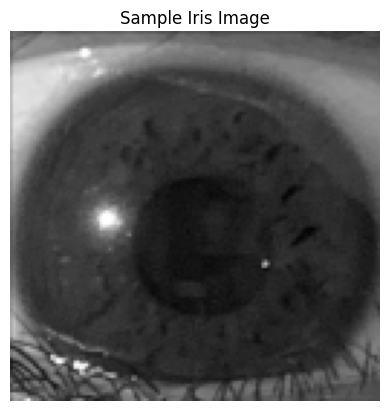

In [6]:
def load_data(data_dir, im_size=(128, 128)):
    X, y = [], []
    images = os.listdir(data_dir)
    for image in images:
        img_path = os.path.join(data_dir, image)
        label = image.split('-')[0]
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, im_size, interpolation=cv2.INTER_AREA)
        X.append(img)
        y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = load_data(direktori[0], im_size=(128, 128))
X_test, y_test = load_data(direktori[1], im_size=(128, 128))

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

plt.imshow(X_train[0], cmap='gray')
plt.title("Sample Iris Image")
plt.axis("off")
plt.show()


##  Manual HOG Feature Extraction

In [7]:
def histogram_oriented_gradients(image, cell_size=(8, 8), block_size=(2, 2),
                                 orientation_bin=9, signedOrientation=False,
                                 block_norm='L2-Hys', eps=1e-5):

    # Mencari gradient x dan gradient y
    grad_x = cv2.Sobel(image, cv2.CV_32F, 1, 0)
    grad_y = cv2.Sobel(image, cv2.CV_32F, 0, 1)

    # Mencari magnitude dan angular
    mag, ang = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

    # Signed OR Unsigned dan memetakkan orientasi bin setiap piksel
    if not signedOrientation:
        ang = ang % 180
        bin_ = np.int32(orientation_bin*ang/(180))
    else:
        bin_ = np.int32(orientation_bin*ang/(2*180))

    # Proses membuat orientation histogram
    num_cells_row = int(image.shape[0] // cell_size[0]) # Jumlah cell dalam baris
    num_cells_col = int(image.shape[1] // cell_size[1]) # Jumlah cell dalam kolom
    orientation_hist = np.zeros((num_cells_row, num_cells_col, orientation_bin)) # Inisialisasi array untuk histogram orientasi
    i, nr = 0, 0
    while i < image.shape[0]:
        j = 0
        nc = 0
        while j < image.shape[1]:
            bin_p = bin_[i:i+cell_size[0],j:j+cell_size[1]] # Mengambil peta orientasi pada cell
            mag_p = mag[i:i+cell_size[0],j:j+cell_size[1]]  # Mengambil nilai magnitude pada cell
            hist = np.bincount(bin_p.ravel(), mag_p.ravel(), orientation_bin) # Menghitung nilai histogram setiap bin
            for b in range(hist.shape[0]):
                orientation_hist[nr, nc, b] = hist[b]
            nc+=1
            j += cell_size[1]
            if j == cell_size[1]*num_cells_col:
                break
        nr+=1
        i += cell_size[0]
        if i == cell_size[0]*num_cells_row:
            break

    # Proses normalisasi blok
    n_block_row = (num_cells_row - block_size[0]) + 1 # Menghitung jumlah block dalam baris
    n_block_col = (num_cells_col - block_size[1]) + 1 # Menghitung jumlah block dalam kolom
    if n_block_row >= 1 and n_block_col >= 1:
        norm_blocks = np.zeros((n_block_row, n_block_col,
                                block_size[0], block_size[1],
                                orientation_bin))
        for r in range(n_block_row):
            for c in range(n_block_col):
                block = orientation_hist[r:r + block_size[0], c:c + block_size[1], :]
                if block_norm == 'L1':
                    out = block / (np.sum(np.abs(block)) + eps)
                elif block_norm == 'L1-sqrt':
                    out = np.sqrt(block / (np.sum(np.abs(block)) + eps))
                elif block_norm == 'L2':
                    out = block / np.sqrt(np.sum(block ** 2) + eps ** 2)
                elif block_norm == 'L2-Hys':
                    out = block / np.sqrt(np.sum(block ** 2) + eps ** 2)
                    out = np.minimum(out, 0.2)
                    out = out / np.sqrt(np.sum(out ** 2) + eps ** 2)
                else:
                    print('Metode block_norm salah')
                norm_blocks[r, c, :] = out

        return norm_blocks.ravel() # Mengembalikan vektor 1-d
    else:
        return None

##  Feature Extraction using HOG

In [8]:
def ekstraksi_fitur(X, bins=9, cell_size=(8, 8), block_size=(2,2),
                   norm='L2-Hys', signed=False, eps=1e-5):
    feature_vector = []
    for image in X:
        fitur = histogram_oriented_gradients(image, cell_size=cell_size,
                                            block_size=block_size, orientation_bin=bins,
                                            signedOrientation=signed, block_norm=norm,
                                            eps=eps)
        feature_vector.append(fitur)
    return np.array(feature_vector)

In [9]:
selected_signed = True
selected_cell = (16,16)
selected_bins = 12
selected_block = (2,2)
selected_block_norm = 'L2-Hys'

In [10]:
X_train_feature = ekstraksi_fitur(X_train, bins=selected_bins, cell_size=selected_cell,
                                    block_size=selected_block, norm=selected_block_norm,
                                    signed=selected_signed, eps=1e-5)

X_train_feature = pd.DataFrame(X_train_feature)
X_train_feature.head()

,0,1,2,3,4,5,6,7,8,9,...,2342,2343,2344,2345,2346,2347,2348,2349,2350,2351
0,0.106792,0.106249,0.368133,0.229002,0.010857,0.004245,0.028025,0.015957,0.012878,0.009381,...,0.053063,0.213477,0.182190,0.150031,0.186940,0.093130,0.104668,0.226683,0.170157,0.251446
1,0.108300,0.068813,0.343160,0.189824,0.012842,0.011757,0.041979,0.078497,0.019118,0.004158,...,0.052138,0.201360,0.263379,0.263379,0.164007,0.020714,0.107606,0.112304,0.263379,0.263379
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.189176,0.033387,0.087392,0.120085,0.261460,0.261460,0.173454,0.045695,0.039811,0.228662,...,0.035289,0.015519,0.002589,0.002055,0.026831,0.028773,0.358717,0.150013,0.014570,0.008014
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


##  Model Training (MLPClassifier - Backpropagation) & Hyperparameter Tuning

In [11]:
# random_states = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
random_states = [1]
start_time = time.time()
random_states_param = {'random_state': [], 'trainacc': [], 'testacc': [], 'time_exec': []}
for state in random_states:
    start_timeloop = time.time()
    X_train_feature = ekstraksi_fitur(X_train, bins=selected_bins, cell_size=selected_cell,
                                      block_size=selected_block, norm=selected_block_norm,
                                      signed=selected_signed, eps=1e-5)
    X_test_feature = ekstraksi_fitur(X_test, bins=selected_bins, cell_size=selected_cell,
                                      block_size=selected_block, norm=selected_block_norm,
                                      signed=selected_signed, eps=1e-5)
    backprop_classifier = MLPClassifier(random_state=state)
    backprop_classifier.fit(X_train_feature, y_train)
    score_train = backprop_classifier.score(X_train_feature, y_train)
    score_test = backprop_classifier.score(X_test_feature, y_test)
    timeloop_exec = time.time() - start_timeloop
    random_states_param['random_state'].append(state)
    random_states_param['trainacc'].append(score_train*100)
    random_states_param['testacc'].append(score_test*100)
    random_states_param['time_exec'].append(timeloop_exec)
time_exec = time.time() - start_time

In [12]:
random_states_param = pd.DataFrame(random_states_param)
print("--- {} detik ---".format(float(time_exec)))
print("--- {} menit ---".format(float(time_exec)/60))
random_states_param.sort_values(by=['testacc'], ascending=False)

--- 45.79538607597351 detik ---
--- 0.7632564345995585 menit ---


,random_state,trainacc,testacc,time_exec
0,1,100.0,91.6,45.794859


In [13]:
selected_state = 1

In [14]:
learning_rates = [10, 1, 0.1, 0.001, 0.0001, 0.00001]
start_time = time.time()
learning_rates_param = {'learning_rate': [], 'trainacc': [], 'testacc': [], 'time_exec': []}
for lr in learning_rates:
    start_timeloop = time.time()
    X_train_feature = ekstraksi_fitur(X_train, bins=selected_bins, cell_size=selected_cell,
                                      block_size=selected_block, norm=selected_block_norm,
                                      signed=selected_signed, eps=1e-5)
    X_test_feature = ekstraksi_fitur(X_test, bins=selected_bins, cell_size=selected_cell,
                                      block_size=selected_block, norm=selected_block_norm,
                                      signed=selected_signed, eps=1e-5)
    backprop_classifier = MLPClassifier(random_state=selected_state, learning_rate_init=lr)
    backprop_classifier.fit(X_train_feature, y_train)
    score_train = backprop_classifier.score(X_train_feature, y_train)
    score_test = backprop_classifier.score(X_test_feature, y_test)
    timeloop_exec = time.time() - start_timeloop
    learning_rates_param['learning_rate'].append(lr)
    learning_rates_param['trainacc'].append(score_train*100)
    learning_rates_param['testacc'].append(score_test*100)
    learning_rates_param['time_exec'].append(timeloop_exec)
time_exec = time.time() - start_time

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
learning_rates_param = pd.DataFrame(learning_rates_param)
print("--- {} detik ---".format(float(time_exec)))
print("--- {} menit ---".format(float(time_exec)/60))
learning_rates_param.sort_values(by=['testacc'], ascending=False)

--- 196.52541089057922 detik ---
--- 3.275423514842987 menit ---


,learning_rate,trainacc,testacc,time_exec
3,0.00100,100.000000,91.600000,41.795235
4,0.00010,99.000000,86.733333,42.623320
5,0.00001,57.200000,43.866667,42.792927
0,10.00000,3.333333,3.333333,7.176816
1,1.00000,3.333333,3.333333,41.522319
2,0.10000,3.333333,3.333333,20.614048


In [16]:
selected_learning_rates = 0.001

In [17]:
epochs = [10, 50, 100, 200, 250, 300, 350]
start_time = time.time()
epochs_param = {'epoch': [], 'trainacc': [], 'testacc': [], 'time_exec': []}
for epoch in epochs:
    start_timeloop = time.time()
    X_train_feature = ekstraksi_fitur(X_train, bins=selected_bins, cell_size=selected_cell,
                                      block_size=selected_block, norm=selected_block_norm,
                                      signed=selected_signed, eps=1e-5)
    X_test_feature = ekstraksi_fitur(X_test, bins=selected_bins, cell_size=selected_cell,
                                      block_size=selected_block, norm=selected_block_norm,
                                      signed=selected_signed, eps=1e-5)
    backprop_classifier = MLPClassifier(random_state=selected_state,
                                        learning_rate_init=selected_learning_rates,
                                        max_iter=epoch)
    backprop_classifier.fit(X_train_feature, y_train)
    score_train = backprop_classifier.score(X_train_feature, y_train)
    score_test = backprop_classifier.score(X_test_feature, y_test)
    timeloop_exec = time.time() - start_timeloop
    epochs_param['epoch'].append(epoch)
    epochs_param['trainacc'].append(score_train*100)
    epochs_param['testacc'].append(score_test*100)
    epochs_param['time_exec'].append(timeloop_exec)
time_exec = time.time() - start_time

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
epochs_param = pd.DataFrame(epochs_param)
print("--- {} detik ---".format(float(time_exec)))
print("--- {} menit ---".format(float(time_exec)/60))
epochs_param.sort_values(by=['testacc'], ascending=False)

--- 210.14028978347778 detik ---
--- 3.502338163057963 menit ---


,epoch,trainacc,testacc,time_exec
5,300,100.000000,91.600000,43.164216
4,250,100.000000,91.600000,41.411159
3,200,100.000000,91.600000,39.621690
6,350,100.000000,91.600000,40.593184
2,100,100.000000,90.933333,23.899673
1,50,100.000000,88.866667,14.226825
0,10,79.266667,62.533333,7.222794


In [19]:
selected_epoch = 200

In [20]:
hidden_sizes = [(10,32,40,100,), (100,50,30,), (26,25,), (20,30,), (100,), (62,), (50,), (10),]
start_time = time.time()
hidden_sizes_param = {'hidden_size': [], 'trainacc': [], 'testacc': [], 'time_exec': []}
for hs in hidden_sizes:
    start_timeloop = time.time()
    X_train_feature = ekstraksi_fitur(X_train, bins=selected_bins, cell_size=selected_cell,
                                      block_size=selected_block, norm=selected_block_norm,
                                      signed=selected_signed, eps=1e-5)
    X_test_feature = ekstraksi_fitur(X_test, bins=selected_bins, cell_size=selected_cell,
                                      block_size=selected_block, norm=selected_block_norm,
                                      signed=selected_signed, eps=1e-5)
    backprop_classifier = MLPClassifier(random_state=selected_state,
                                        learning_rate_init=selected_learning_rates,
                                        max_iter=selected_epoch,
                                        hidden_layer_sizes=hs)
    backprop_classifier.fit(X_train_feature, y_train)
    score_train = backprop_classifier.score(X_train_feature, y_train)
    score_test = backprop_classifier.score(X_test_feature, y_test)
    timeloop_exec = time.time() - start_timeloop
    hidden_sizes_param['hidden_size'].append(hs)
    hidden_sizes_param['trainacc'].append(score_train*100)
    hidden_sizes_param['testacc'].append(score_test*100)
    hidden_sizes_param['time_exec'].append(timeloop_exec)
time_exec = time.time() - start_time

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [21]:
hidden_sizes_param = pd.DataFrame(hidden_sizes_param)
print("--- {} detik ---".format(float(time_exec)))
print("--- {} menit ---".format(float(time_exec)/60))
hidden_sizes_param.sort_values(by=['testacc'], ascending=False)

--- 259.7309491634369 detik ---
--- 4.328849152723948 menit ---


,hidden_size,trainacc,testacc,time_exec
4,"(100,)",100.000000,91.600000,47.989160
5,"(62,)",100.000000,88.800000,33.870499
6,"(50,)",100.000000,87.266667,42.841967
1,"(100, 50, 30)",100.000000,81.733333,48.402432
2,"(26, 25)",100.000000,79.600000,22.935531
3,"(20, 30)",100.000000,78.866667,24.425529
0,"(10, 32, 40, 100)",100.000000,66.800000,22.604035
7,10,94.133333,66.466667,16.661006


In [22]:
selected_hidden_layer = (100,)

In [23]:
activations = ['logistic', 'tanh', 'relu']
start_time = time.time()
activations_param = {'activation': [], 'trainacc': [], 'testacc': [], 'time_exec': []}
for act in activations:
    start_timeloop = time.time()
    X_train_feature = ekstraksi_fitur(X_train, bins=selected_bins, cell_size=selected_cell,
                                      block_size=selected_block, norm=selected_block_norm,
                                      signed=selected_signed, eps=1e-5)
    X_test_feature = ekstraksi_fitur(X_test, bins=selected_bins, cell_size=selected_cell,
                                      block_size=selected_block, norm=selected_block_norm,
                                      signed=selected_signed, eps=1e-5)
    backprop_classifier = MLPClassifier(random_state=selected_state,
                                        learning_rate_init=selected_learning_rates,
                                        max_iter=selected_epoch,
                                        hidden_layer_sizes=selected_hidden_layer,
                                        activation=act)
    backprop_classifier.fit(X_train_feature, y_train)
    score_train = backprop_classifier.score(X_train_feature, y_train)
    score_test = backprop_classifier.score(X_test_feature, y_test)
    timeloop_exec = time.time() - start_timeloop
    activations_param['activation'].append(act)
    activations_param['trainacc'].append(score_train*100)
    activations_param['testacc'].append(score_test*100)
    activations_param['time_exec'].append(timeloop_exec)
time_exec = time.time() - start_time

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [24]:
activations_param = pd.DataFrame(activations_param)
print("--- {} detik ---".format(float(time_exec)))
print("--- {} menit ---".format(float(time_exec)/60))
activations_param.sort_values(by=['testacc'], ascending=False)

--- 117.60995721817017 detik ---
--- 1.9601659536361695 menit ---


,activation,trainacc,testacc,time_exec
0,logistic,100.0,92.133333,42.266012
1,tanh,100.0,91.933333,33.748739
2,relu,100.0,91.600000,41.594512


In [25]:
selected_activation = 'logistic'

In [26]:
selected_signed = True
selected_cell = (16,16)
selected_bins = 12
selected_block = (2,2)
selected_block_norm = 'L2-Hys'

selected_state = 1
selected_learning_rates = 0.001
selected_epoch = 200
selected_hidden_layer = (100,)
selected_activation = 'logistic'

In [30]:
feature_extraction_result = ekstraksi_fitur(X_train, bins=selected_bins, cell_size=selected_cell,
                                            block_size=selected_block, norm=selected_block_norm,
                                            signed=selected_signed, eps=1e-5)
backprop_classifier = MLPClassifier(random_state=selected_state,
                                    learning_rate_init=selected_learning_rates,
                                    max_iter=selected_epoch,
                                    hidden_layer_sizes=selected_hidden_layer,
                                    activation=selected_activation)
backprop_classifier.fit(feature_extraction_result, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', random_state=1)

In [31]:
y_train

array(['10', '10', '11', ..., '11', '11', '10'], dtype='<U2')

##  Evaluation Metrics

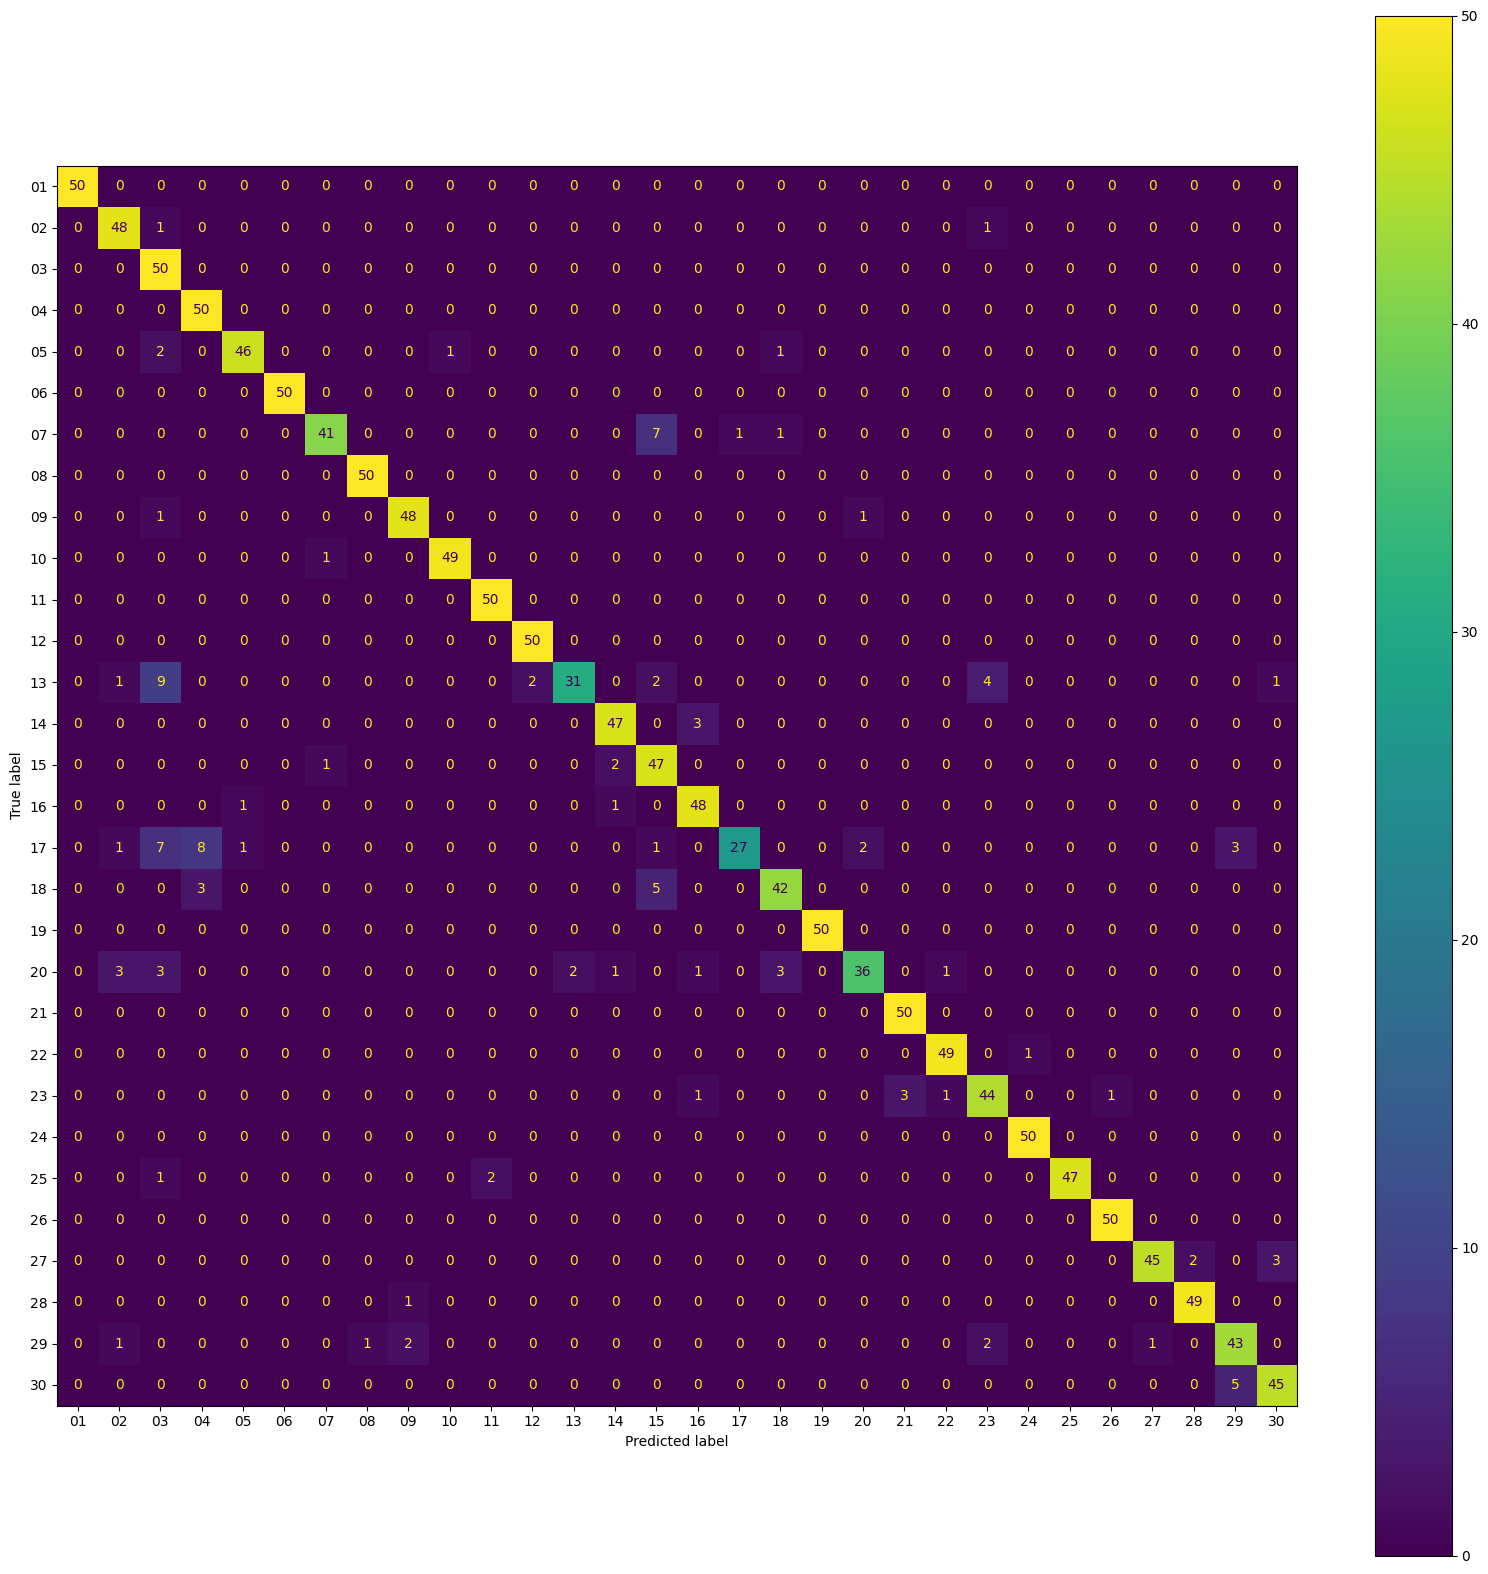

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.pyplot import figure
# import sys
# plt_1 = plt.figure(figsize=(3, 6))
y_predict = backprop_classifier.predict(X_test_feature)
# np.set_printoptions(threshold=sys.maxsize)
# y_predict
# print(len(y_predict))
cm = confusion_matrix(y_test, y_predict, labels=backprop_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=backprop_classifier.classes_)
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax)
# disp.plot()

plt.show()

In [40]:
print("Accuracy:", accuracy_score(y_test, y_predict))
print("\nClassification Report:")
print(classification_report(y_test, y_predict))


Accuracy: 0.9213333333333333

Classification Report:
              precision    recall  f1-score   support

          01       1.00      1.00      1.00        50
          02       0.89      0.96      0.92        50
          03       0.68      1.00      0.81        50
          04       0.82      1.00      0.90        50
          05       0.96      0.92      0.94        50
          06       1.00      1.00      1.00        50
          07       0.95      0.82      0.88        50
          08       0.98      1.00      0.99        50
          09       0.94      0.96      0.95        50
          10       0.98      0.98      0.98        50
          11       0.96      1.00      0.98        50
          12       0.96      1.00      0.98        50
          13       0.94      0.62      0.75        50
          14       0.92      0.94      0.93        50
          15       0.76      0.94      0.84        50
          16       0.91      0.96      0.93        50
          17       0.96     

In [33]:
score_train = backprop_classifier.score(X_train_feature, y_train)
score_test = backprop_classifier.score(X_test_feature, y_test)

print(score_train * 100)
print(score_test *100)

100.0
92.13333333333334


## Save Model

In [34]:
import joblib
joblib.dump(backprop_classifier, 'backprop_model.joblib')

['backprop_model.joblib']